In [1]:
!pip install transformers
!pip install torch

In [2]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.nn import functional as F

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [3]:
import requests

url = "https://s3.amazonaws.com/fast-ai-nlp/amazon_review_full_csv.tgz"
filename = url.split("/")[-1]

response = requests.get(url)

if response.status_code == 200:
  with open(filename, 'wb') as f:
    f.write(response.content)
  print(f"Downloaded {filename}")
else:
  print(f"Failed to download the file: {response.status_code}")

Downloaded amazon_review_full_csv.tgz


In [4]:
import tarfile

with tarfile.open(filename, "r:gz") as tar:
  tar.extractall()

print(f"Extracted files from {filename}")

Extracted files from amazon_review_full_csv.tgz


In [5]:
%cd amazon_review_full_csv
!pwd

/content/amazon_review_full_csv
/content/amazon_review_full_csv


In [6]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


In [7]:
train.rename(columns = {'3':"rating","more like funchuck":"Title",'''Gave this to my dad for a gag gift after directing "Nunsense," he got a reall kick out of it!''':"review"},inplace = True)
train.head()

,rating,Title,review
0,5,Inspiring,I hope a lot of people hear this cd. We need m...
1,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
3,5,Too good to be true,Probably the greatest soundtrack in history! U...
4,5,There's a reason for the price,"There's a reason this CD is so expensive, even..."


In [8]:
test.rename(columns = {'1':'rating',"mens ultrasheer":"Title",'''This model may be ok for sedentary types, but I'm active and get around alot in my job - consistently found these stockings rolled up down by my ankles! Not Good!! Solution: go with the standard compression stocking, 20-30, stock #114622. Excellent support, stays up and gives me what I need. Both pair of these also tore as I struggled to pull them up all the time. Good riddance/bad investment!''':"review"}, inplace = True)
test.head()

,rating,Title,review
0,4,Surprisingly delightful,This is a fast read filled with unexpected hum...
1,2,"Works, but not as advertised",I bought one of these chargers..the instructio...
2,2,Oh dear,I was excited to find a book ostensibly about ...
3,2,Incorrect disc!,"I am a big JVC fan, but I do not like this mod..."
4,2,Incorrect Disc,"I love the style of this, but after a couple y..."


(array([129999.,      0., 130000.,      0.,      0., 130000.,      0.,
        130000.,      0., 130000.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

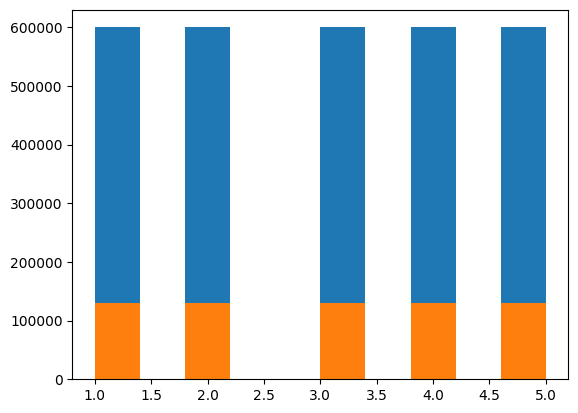

In [9]:
import matplotlib.pyplot as plt
plt.hist(train['rating'])
plt.hist(test['rating'])

In [10]:
def convert_ratings_to_sentiment(rating):
    if rating > 3:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'
train['sentiment'] = train['rating'].apply(convert_ratings_to_sentiment)
test['sentiment'] = test['rating'].apply(convert_ratings_to_sentiment)


In [11]:
train.head()

,rating,Title,review,sentiment
0,5,Inspiring,I hope a lot of people hear this cd. We need m...,positive
1,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,positive
2,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...,positive
3,5,Too good to be true,Probably the greatest soundtrack in history! U...,positive
4,5,There's a reason for the price,"There's a reason this CD is so expensive, even...",positive


In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
max_len = 128
train_encodings = tokenizer(train['review'].tolist(), truncation=True, padding=True, max_length=max_len)
test_encodings = tokenizer(test['review'].tolist(), truncation=True, padding=True, max_length=max_len)

In [14]:
label_dict = {'negative': 0, 'neutral': 1, 'positive': 2}
train_labels = [label_dict[label] for label in train['sentiment']]
test_labels = [label_dict[label] for label in test['sentiment']]


In [15]:
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(train_labels))
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']), torch.tensor(test_encodings['attention_mask']), torch.tensor(test_labels))

In [16]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 3
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss:.2f}')


In [ ]:
model.eval()
total_eval_accuracy = 0
for batch in test_loader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, attention_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).flatten()

    total_eval_accuracy += (preds == labels).cpu().numpy().mean()

avg_accuracy = total_eval_accuracy / len(test_loader)
print(f'Accuracy: {avg_accuracy:.2f}')